**Explanation of the Script
Loading and Preprocessing Data:**

Images are loaded from the specified folder and resized to fixed dimensions (img_height, img_width).
They are normalized to values between 0 and 1, and the corresponding labels (from .txt files) are read and tokenized at the character level.
The label sequences are padded to match the model’s expected output timesteps (32).
Model Architecture:

The CNN part of the model consists of three convolutional layers followed by max pooling layers to downsample the image.
The output of the CNN is reshaped and fed into a bidirectional LSTM, which can handle sequences of data (in this case, sequences of characters).
The TimeDistributed layer is used to apply the output dense layer for character classification across all timesteps.
Model Training:

The model is compiled with the sparse_categorical_crossentropy loss, which is suitable for classification problems where the labels are integers (as we used tokenized sequences).
The model is trained for 50 epochs on the dataset, with validation data being used for evaluation during training.
Saving the Model and Tokenizer:

After training, the model and tokenizer are saved so they can be used later for predictions or further fine-tuning.
Running on Colab:
Upload your handwritten images and corresponding text files into a folder in your Colab environment (e.g., /content/handwritten_dataset/).
Run the script. After training, the model and tokenizer will be saved as files (handwriting_model.h5 and tokenizer.pickle).

In [ ]:
# Install necessary dependencies in Colab (uncomment if required)
# !pip install tensorflow

import os
import glob
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Path to your dataset folder containing images and text files
dataset_folder = '/content/dataset/'

# Parameters
img_height = 64
img_width = 256
batch_size = 32
epochs = 50

# Function to load images and their corresponding text labels
def load_data(dataset_folder):
    images = []
    labels = []
    img_files = glob.glob(os.path.join(dataset_folder, '*.png'))  # Assuming the images are .png files
    for img_file in img_files:
        # Load image
        img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_width, img_height))
        img = img.astype('float32') / 255.0  # Normalize to [0, 1]
        images.append(img)

        # Load corresponding label (assumed to have the same name as the image but .txt extension)
        label_file = img_file.replace('.png', '.txt')
        with open(label_file, 'r', encoding='utf-8') as f:
            label = f.read().strip()
        labels.append(label)

    return np.array(images), labels

# Load the data
images, labels = load_data(dataset_folder)
images = np.expand_dims(images, axis=-1)  # Add channel dimension for grayscale images

# Tokenize the labels (Convert text labels into sequences of integers)
tokenizer = Tokenizer(char_level=True)  # Character-level tokenizer
tokenizer.fit_on_texts(labels)
sequences = tokenizer.texts_to_sequences(labels)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Including padding

# The model's output will have 32 timesteps after downsampling, so we need to pad the labels accordingly
output_timesteps = 32  # Based on the model architecture, the output sequence will have 32 timesteps

# Pad sequences to ensure consistent length matching the output timesteps
labels_padded = pad_sequences(sequences, maxlen=output_timesteps, padding='post')

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_padded, test_size=0.2, random_state=42)

# Build the model (A simple CNN + RNN for handwritten text recognition)
def build_model(img_width, img_height, vocab_size, output_timesteps):
    inputs = tf.keras.Input(shape=(img_height, img_width, 1))  # Grayscale image
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Flatten and add recurrent layer
    x = tf.keras.layers.Reshape((img_width // 8, img_height // 8 * 128))(x)  # Reshape for RNN input
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)

    # Output layer for character-level classification
    outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size, activation='softmax'))(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Compile the model
model = build_model(img_width, img_height, vocab_size, output_timesteps)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model
history = model.fit(X_train, np.expand_dims(y_train, axis=-1),
                    validation_data=(X_val, np.expand_dims(y_val, axis=-1)),
                    batch_size=batch_size, epochs=epochs)

# Save the model after training
model.save('/content/handwriting_model.h5')

# Optional: You can save the tokenizer for later use
import pickle
with open('/content/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 256, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 256, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 128, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 128, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 32, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 32, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 32, 256)             │       1,180,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 32, 38)              │           9,766 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,110 (4.89 MB)

 Trainable params: 1,283,110 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6538 - loss: 2.1683 - val_accuracy: 0.8458 - val_loss: 0.8527
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8354 - loss: 0.9050 - val_accuracy: 0.8458 - val_loss: 0.7452
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8314 - loss: 0.7847 - val_accuracy: 0.8458 - val_loss: 0.6687
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8407 - loss: 0.6848 - val_accuracy: 0.8458 - val_loss: 0.6460
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8393 - loss: 0.6746 - val_accuracy: 0.8462 - val_loss: 0.6634
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8401 - loss: 0.6801 - val_accuracy: 0.8458 - val_loss: 0.6418
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8280 - loss: 0.7118 - val_accuracy: 0.8458 - val_loss: 0.6527
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8335 - loss: 0.6974 - val_accuracy: 0.8458 - val_loss:

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import pickle
from google.colab import files
import io
from PIL import Image

# Load the saved model
model = tf.keras.models.load_model('/content/handwriting_model.h5')

# Load the tokenizer
with open('/content/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Image dimensions used during training
img_height = 64
img_width = 256

# Function to preprocess the image (same as during training)
def preprocess_image(image):
    img = np.array(image)  # Convert to NumPy array

    # Check if the image is already in grayscale
    if len(img.shape) == 3:  # If image has 3 channels, convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    img = cv2.resize(img, (img_width, img_height))  # Resize to match training input size
    img = img.astype('float32') / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to decode predictions (convert from integer sequence to text)
def decode_predictions(preds, tokenizer):
    preds = np.argmax(preds, axis=-1)  # Get the index of the highest probability character at each timestep
    decoded = []
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}

    for pred in preds[0]:  # Take the first sample from the batch
        if pred == 0:  # Padding token
            continue
        decoded.append(reverse_word_index.get(pred, ''))  # Get the character or blank if not in dict

    return ''.join(decoded)

# Upload image using Colab's file upload functionality
uploaded = files.upload()

# Assuming only one image is uploaded, get the file name
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

    # Open the uploaded image using PIL
    image = Image.open(io.BytesIO(uploaded[filename]))

    # Preprocess the uploaded image
    preprocessed_img = preprocess_image(image)

    # Make predictions
    predictions = model.predict(preprocessed_img)

    # Decode predictions into readable text
    decoded_text = decode_predictions(predictions, tokenizer)

    print("Predicted Text:", decoded_text)


Saving 0218-010-01-01-01.png to 0218-010-01-01-01.png
Uploaded file: 0218-010-01-01-01.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Predicted Text: d


**Grayscale Check:**

Before attempting to convert the image to grayscale using cv2.cvtColor, the script now checks if the image already has a single channel (grayscale). If so, it skips the conversion step.

**Upload Image:**
When you run the script in Colab, it will prompt you to upload an image from your local machine.

**Prediction Output:**
Once the image is uploaded, the script will preprocess the image, make predictions, and output the predicted text in the console.

Saving 0218-010-01-01-11.png to 0218-010-01-01-11.png
Uploaded file: 0218-010-01-01-11.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


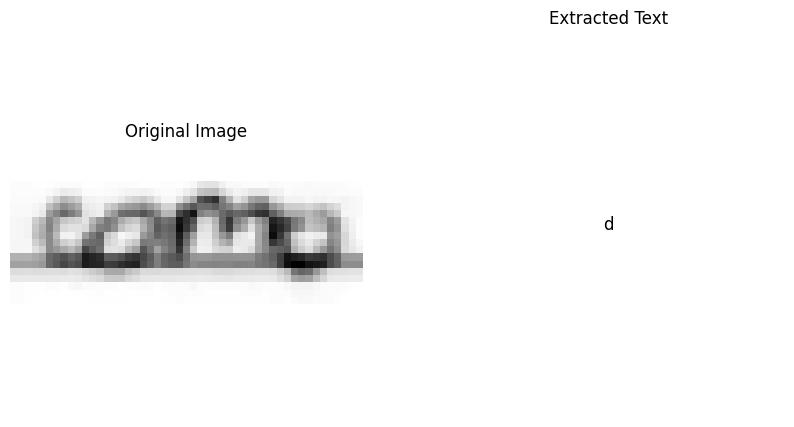

Predicted Text: d


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import pickle
from google.colab import files
import io
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('/content/handwriting_model.h5')

# Load the tokenizer
with open('/content/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Image dimensions used during training
img_height = 64
img_width = 256

# Function to preprocess the image (same as during training)
def preprocess_image(image):
    img = np.array(image)  # Convert to NumPy array

    # Check if the image is already in grayscale
    if len(img.shape) == 3:  # If image has 3 channels, convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    img = cv2.resize(img, (img_width, img_height))  # Resize to match training input size
    img = img.astype('float32') / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to decode predictions (convert from integer sequence to text)
def decode_predictions(preds, tokenizer):
    preds = np.argmax(preds, axis=-1)  # Get the index of the highest probability character at each timestep
    decoded = []
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}

    for pred in preds[0]:  # Take the first sample from the batch
        if pred == 0:  # Padding token
            continue
        decoded.append(reverse_word_index.get(pred, ''))  # Get the character or blank if not in dict

    return ''.join(decoded)

# Upload image using Colab's file upload functionality
uploaded = files.upload()

# Assuming only one image is uploaded, get the file name
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

    # Open the uploaded image using PIL
    image = Image.open(io.BytesIO(uploaded[filename]))

    # Preprocess the uploaded image
    preprocessed_img = preprocess_image(image)

    # Make predictions
    predictions = model.predict(preprocessed_img)

    # Decode predictions into readable text
    decoded_text = decode_predictions(predictions, tokenizer)

    # Display the original image and the extracted text
    plt.figure(figsize=(10,5))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Display the extracted text
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, decoded_text, fontsize=12, ha='center', va='center')
    plt.title("Extracted Text")
    plt.axis('off')

    plt.show()

    print("Predicted Text:", decoded_text)
